In [80]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from mobo.utils import calculate_var

In [81]:
# from mobo.surrogate_model import BoTorchSurrogateModelReapeat, BoTorchSurrogateModel
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [82]:
# .\result\exp4d\optimization_4\marsdet\0\state_dict_noise.pt

# path = Path("../result/exp4d/unroll_new/marsdet/0/")
# path = Path("../result/exp/unroll_new/raqnehvi/0/")
# path = Path("../result/peaksS5R3/default/mars/0/")
# path = Path("../result/peaks/default/qnehvi/0/")
path = Path(r"..\good results\peaksS5R3\risk-averseb4_1\qnehvi\0")
path = Path(r"..\good results\peaksS5R3\risk-averseb4_1\mars\0")
# path = Path(r"..\good results\peaks\risk-averseb4\raqnehvi\0")
# path = Path("../result/peaks/default/mars/0/")

# state_dict = torch.load(path / "state_dict.pt")
# state_dict_noise = torch.load(path / "state_dict_noise.pt")

eval_samples = pd.read_csv(path / "EvaluatedSamples.csv")
approx_all_df = pd.read_csv(path / "ApproximationAll.csv")

# paretoEval_list.append(pd.read_csv(csv_folder + "ParetoFrontEvaluated.csv"))
# with open(csv_folder + "args.yml") as f:
#     yml_list.append(yaml.load(f, Loader=yaml.SafeLoader))
# paretoGP_list.append(pd.read_csv(csv_folder + "ParetoFrontApproximation.csv"))
paretoGP = pd.read_csv(path / "ParetoFrontApproximation.csv")
paretoEval = pd.read_csv(path / "ParetoFrontEvaluated.csv")
paretoApprox = pd.read_csv(path / "ParetoFrontApproximation.csv")

def get_data_of_step(pareto_approx_df, selected_iteration):
    filtered_data = pareto_approx_df[pareto_approx_df["iterID"] == selected_iteration]
    return filtered_data

eval_samples = pd.read_csv(path / "EvaluatedSamples.csv")
eval_samples.columns.to_list()

args_yaml = path / "args.yml"
args = yaml.safe_load(args_yaml.open("r"))

batch_size = args["general"]["batch_size"]
init_samples = args["general"]["n_init_sample"]
n_obj = args["general"]["n_obj"]

sub=0
algo_name = args["general"]["algo"]
if "det" in algo_name:
    sub=1

if "exp" in args["general"]["problem"]:
    eval_samples = eval_samples[~(eval_samples["iterID"] == eval_samples["iterID"].max())]
    sub = 1
    
n_obj -= sub
    
# bool array for sobol experiments vs optimization
sobol = np.where(eval_samples["iterID"] == 0, True, False)


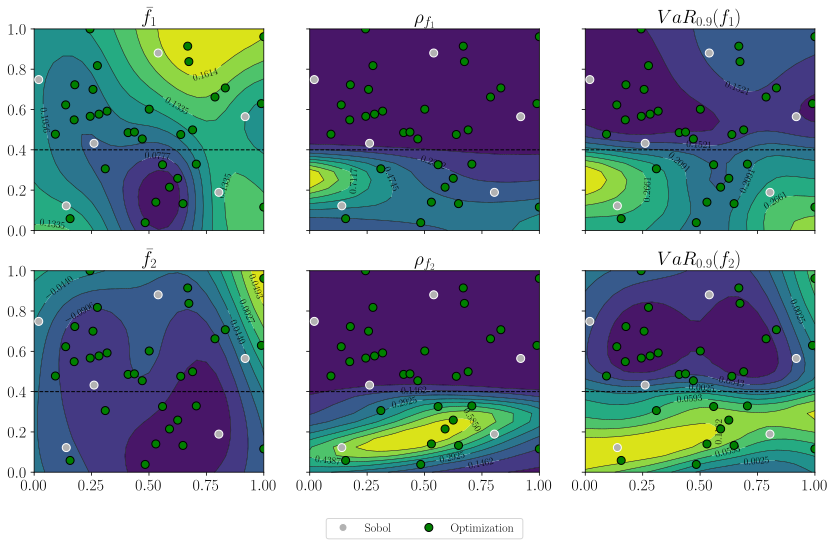

In [108]:
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe


plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Helvetica"],
        # font size
        "font.size": 16,
    }
)

colors = defaultColors

# Assuming 'approx_all_i' is your DataFrame and 'n_grid' is defined
n_grid = 25

# Use a continuous colormap for float-valued columns
labels = eval_samples["iterID"]
norm = plt.Normalize(labels.min(), labels.max())
cmap = plt.cm.viridis

# lightblue to darkblue colormap
cmap = plt.cm.Greens

colors = cmap(norm(labels.unique()))

green = [0.0, 0.5, 0.0, 1]
colors = [green] * len(labels)

colors[0] = [0.7, 0.7, 0.7, 1]
labels = labels.round(2)

objective_list = list(range(1, n_obj + 1))
data_keys = ["F_", "rho_F_", "mvar_F_"]

iter = approx_all_df["iterID"].max()

approx_all_i = approx_all_df[approx_all_df["iterID"] == iter]
# Data reshaping
x = approx_all_i["x1"].values.reshape((n_grid, n_grid))
y = approx_all_i["x2"].values.reshape((n_grid, n_grid))

fig, axs = plt.subplots(len(objective_list), len(data_keys), figsize=(14, 8))

for i, obj_idx in enumerate(objective_list):
    for j, key in enumerate(data_keys):
        # Construct the key for the current iteration
        current_key = f"{key}{obj_idx}"
        # Reshape the data for the current plot
        z = approx_all_i[current_key].values.reshape((n_grid, n_grid))
        levels = np.linspace(z.min(), z.max(), 10)
        # Create contour plot
        img = axs[i, j].contourf(x[0], y[:, 0], z, levels=levels, cmap="viridis")
        c = axs[i, j].contour(
            x[0],
            y[:, 0],
            z,
            levels=levels,
            colors="black",
            linestyles="solid",
            linewidths=0.5,
        )
        axs[i, j].clabel(
            c, c.levels[::2], inline=True, fontsize=10, colors="black", zorder=20
        )
        
        # horizontal dotted line at x2 = 0.2
        axs[i, j].axhline(y=0.4, color="black", linestyle="--", linewidth=1)

        for idx, label in enumerate(labels):
            x1 = eval_samples[eval_samples["iterID"] == label]["x1"][idx]
            x2 = eval_samples[eval_samples["iterID"] == label]["x2"][idx]

            if label == 0:
                mec = "white"
                tc = "white"
                name = "Sobol"
            else:
                mec = "black"
                tc = "black"
                name = f"Optimization"
                # axs[i, j].text(
                #     x1,
                #     x2,
                #     str(label),
                #     fontsize=8,
                #     zorder=30,
                #     # path_effects=[pe.Stroke(linewidth=0.2, foreground="white")],
                #     color=tc,
                #     ha="center",
                #     va="center",
                #     # bbox=dict(
                #     #     facecolor=colors[label], edgecolor="black", boxstyle="round,pad=0.3"
                #     # ),
                # )
                
            axs[i, j].plot(
                x1,
                x2,
                color=colors[label],
                markeredgecolor=mec,
                linestyle="None",
                marker="o",
                markersize=8,
                zorder=29,
                label=name,
            )

        # Latex formatting
        if key == "F_":
            axs[i, j].set_title(f"$\\bar{{f}}_{obj_idx}$")
        if key == "rho_F_":
            axs[i, j].set_title(f"$\\rho_{{f_{obj_idx}}}$")
        if key == "mvar_F_":
            axs[i, j].set_title(f"$VaR_{{0.9}}({{f_{obj_idx}}})$")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[1,1].legend(by_label.values(), by_label.keys(),
        #    bottom center legend, below the plots
              bbox_to_anchor=(0.5, -0.2),
              loc='upper center',
              ncol=2,
              fontsize=12
              )
# only show axis labels on the bottom row
for ax in axs.flat:
    ax.label_outer()

# plt.tight_layout()
plt.show()

path_folder = Path("./Plots") / path.parts[2]
path_folder.mkdir(exist_ok=True, parents=True)
# plt.savefig(path_folder / ("_".join(path.parts[3:-1]) + "_IOplot.pdf"), dpi=600, format="pdf")